# CS5841 Keras "Tutorial" Project
## Wei Qian

In this project, we will build a simple neural network for classification using keras and train it on the Fashion-MNIST dataset.

Fashion-MNIST is a dataset of article images- consisting of a training set of 60,000 examples and a test test of 10,000 examples. Each example is a 28x28 grayscale imaage, associated with a label from 10 classes in clothing.

Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation with user friendlines, modularity and easy extensibility.

### Environment Settings

We build keras based on our Jupyter notebook in Linux environment. We need to both install keras package and TensorFlow backend first in the terminal using PyPI command.

$ pip install keras

$ pip install tensorflow

### Loading Data

Packets imports. 

In [4]:
# imports for numpy handling and plotting
import numpy as np
import matplotlib.pyplot as plt
import struct

# imports for keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation

# imports for sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

# imports for IPython
from IPython.display import Image

First, we need to download the dataset, we can get the original dataset on https://github.com/zalandoresearch/fashion-mnist Here, we show a way how to decode the ubyte image data to the numpy array that we can use for keras. Read the file information and decode the image file into pixel data, label file into real number. Alternatively, you can load the data from keras dataset which can be used directly.

    Training set images: t10k-images-idx3-ubyte 
    Training set labels: t10k-labels-idx1-ubyte
    Test set images: train-images-idx3-ubyte
    Test set labels: train-labels-idx1-ubyte

In [5]:
def decode_idx3_ubyte(filename):
    bin_data = open(filename, 'rb').read()
    # decode header info
    offset = 0
    fmt_header = '>iiii'
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
    #print ('magic number:%d, image number: %d, image size: %d*%d' % (magic_number, num_images, num_rows, num_cols))
    # decode dataset
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)
    fmt_image = '>' + str(image_size) + 'B'
    images = np.empty((num_images, num_rows, num_cols))
    for i in range(num_images):
        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
        offset += struct.calcsize(fmt_image)
    return images
 
def decode_idx1_ubyte(filename):
    bin_data = open(filename, 'rb').read()
    # decode header info
    offset = 0
    fmt_header = '>ii'
    magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offset)
    #print ('magic number:%d, image number: %d' % (magic_number, num_images))
    # decode dataset
    offset += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = np.empty(num_images)
    for i in range(num_images):
        labels[i] = struct.unpack_from(fmt_image, bin_data, offset)[0]
        offset += struct.calcsize(fmt_image)
    return labels

train_image = decode_idx3_ubyte('train-images-idx3-ubyte')
print ('training image number: %d, image size: %d*%d' % (train_image.shape[0], train_image.shape[1], train_image.shape[2]))
train_label = decode_idx1_ubyte('train-labels-idx1-ubyte')
print ('training label: %d' % (train_label.shape[0]))
test_image = decode_idx3_ubyte('t10k-images-idx3-ubyte')
print ('test image number: %d, image size: %d*%d' % (test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_label = decode_idx1_ubyte('t10k-labels-idx1-ubyte')
print ('test label: %d' % (test_label.shape[0]))


training image number: 60000, image size: 28*28
training label: 60000
test image number: 10000, image size: 28*28
test label: 10000


After we load the data, we will see that there are 60,000 images in training set and 10,000 images in test set, each image size is 28x28. Then, we can show some expamles of the images. We random choice ten different classes of training label and their images. The image is only represented in grayscale, the background close to 0 and shape close to 255 pixel.

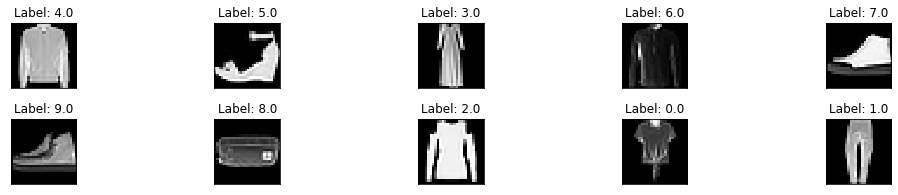

In [6]:
labels=np.zeros(10)
count=0
fig=plt.figure(figsize=(15,3))
while True:
    rd=np.random.randint(len(train_label)) # random choice
    if labels[int(train_label[rd])]==0:
        plt.subplot(2,5,count+1) # plot 10 images for 2 x 5
        plt.tight_layout()
        plt.imshow(train_image[rd],cmap='gray') # show image
        plt.title("Label: {}".format(train_label[rd])) # show label
        plt.xticks([])
        plt.yticks([])
        labels[int(train_label[rd])]=1
        count+=1
    if np.count_nonzero(labels)==10:
        break

Each traning and test label is a digit, representing to one of the following descriptions:
<table style="float:left">
  <tr>
    <th>Label</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
  <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
  <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
  <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
  <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
  <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
  <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>


In order to train our neural network to classify images, we need to turn the image to a very long vector, which is 28 * 28 = 784, we can also normalize the data to speed up traning and reduce error. In addition, for the training and testing labels, we can use "one versus all" encoding to categorize the label. That is, a vector with a length equal to the number of classes, only one value of 1 indicates the truth class of that image and the others are all zeroes. For example, class 2 trouser is represented by [0,0,1,0,0,0,0,0,0,0], class 6 shirt is represented by [0,0,0,0,0,0,1,0,0,0] 

In [7]:
def load_data():
    # decode data
    train_image = decode_idx3_ubyte('train-images-idx3-ubyte')
    train_label = decode_idx1_ubyte('train-labels-idx1-ubyte')
    test_image = decode_idx3_ubyte('t10k-images-idx3-ubyte')
    test_label = decode_idx1_ubyte('t10k-labels-idx1-ubyte')
    
    # change train_image and test_image to dim x*784    
    x_train = train_image.reshape(train_image.shape[0],784)
    x_test = test_image.reshape(test_image.shape[0],784)

    # normalize data
    x_train /= 255
    x_test /= 255
    #print("Training set reshape:", x_train.shape)
    #print("Test set reshape:", x_test.shape)

    # cateforical label
    y_train = np_utils.to_categorical(train_label, 10)
    y_test = np_utils.to_categorical(test_label, 10)
    #print("Training label categorizes:", y_train.shape)
    #print("Test label categorizes:", y_test.shape)
    
    return (x_train, y_train), (x_test, y_test)

<b>K-flod cross validation</b> is a useful way to estimate the performance of the model. We can split the training set into k-flod subsets, everytime, use one subset for testing and the rest subsets for traning. This will give the predication error across k-flod to test the algorithm properly. 

We can use KFlod class from sklearn to implement the k-flod cross validation split process, then fit the model with validation data in keras. The fit function has validation_data attribute that we can use for test data directly. The below cross validation is to choose the batch_size in the fit function. We can aslo use cross validation to choose other parameters.

In [8]:
def cross_validation(batches,x_train,y_train,folds):
    kf=KFold(n_splits=folds) # split to k flods
    accs=[]
    for i in batches:
        acc=0
        for train_index, test_index in kf.split(x_train): # enumerate splits
            x_train_val, x_test_val = x_train[train_index], x_train[test_index] # split training set into validation training set and validation test set 
            y_train_val, y_test_val = y_train[train_index], y_train[test_index] # split traingin label into validation training label and validation test label
            model=get_model() # recreate model each time for fair
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            history=model.fit(x_train_val,y_train_val,validation_data=(x_test_val,y_test_val), batch_size=i, epochs=10, verbose=0)
            acc+=np.mean(history.history['val_accuracy'])
        accs.append(np.round(acc/folds,4))

    # combine 2 1-d arrays to 1 2-d array
    X = np.array(batches) 
    y = np.array(accs)
    result = np.vstack((X, y)).T
    
    # plot the result as a table
    bx=plt.subplot()
    columns=["Batch_size","Validation Accuracy"]
    color=("#E0E0E0","#E0E0E0")
    table=bx.table(cellText=result,colLabels=columns,loc='center',colColours=color)
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1,2)
    bx.axis("off")
    plt.show()

### Creating a keras model

Next, we can create the neural network model for the dataset. The input vector is a 784-dimensional vector, then we can set two hidden layers, each with 512 nodes, and the ouput layer with 10 nodes representing 10 dirfferent classes. 

The sturcture we use is a simple keras sequential model, then add the dense layer to the model. The two hidden layers all use ReLU activation function and the ouput layer uses softmax activation funciton. Since this is a simple neural network, we think this is complex enough to recognize images. We also add dropout as a way to prevent overfitting. 

Here is a figure to display this neural network structure:

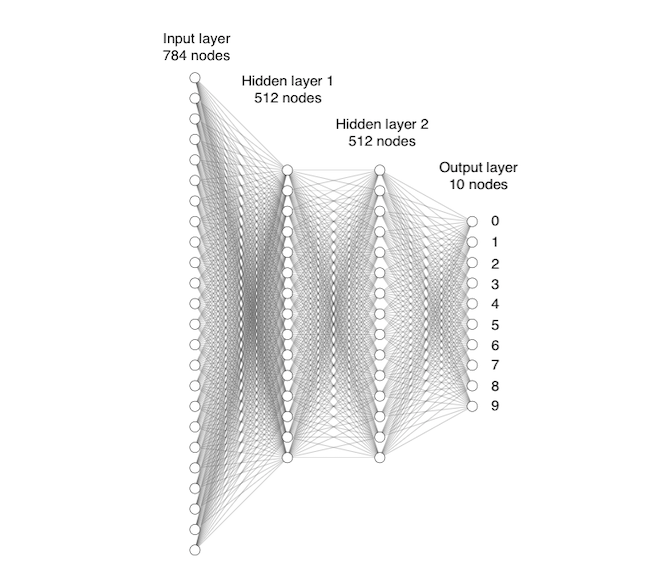

In [9]:
Image(filename='nn.png') 

In [10]:
def get_model():
    model = Sequential() # sequential model

    model.add(Dense(512, activation='relu', input_shape=(784,))) # first hidden layer
    model.add(Dropout(0.1))
 
    model.add(Dense(512, activation='relu')) # second hidden layer
    model.add(Dropout(0.1))

    model.add(Dense(10, activation='softmax')) # output layer
    return model

###  Compiling the model

Now we need to configure the model to be complied. Loss function is string (name of objective function) or objective function or loss instance. Since this is a classification dataset, then we choose 'categorical_crossentropy'. If the model has multiple outputs, you can use a different loss on each output by passing a dictionary or a list of losses. The loss value that will be minimized by the model will then be the sum of all individual losses. For optimizer, there are many choices, like SDG, RMSprop, Adagrad, etc. We use the Adam with default paramter, which is a method of stochastic optimization and it is sutiable for this dataset. To complie the training set and test set, we ensure that we can monitor the accuracy metrix. To specify different metrics for different outputs of a multi-output model, you could also pass a dictionary.

In [11]:
# get model
model=get_model()
# complie sequential model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Fitting the model

When we have complied the model, we can process the trainging data. The parameter of batch_size tells us how many samples we want to use for one update to the model's weights, the parameter of epochs tells us how many times we want to iterate on the training set.

Here, we use 128 for batch_size here and 10 for epochs. This batch_size is chose using <b>5-fold cross valiadation</b> which we defined in loading data part. The value of k=5 is chosen to provide a baseline for both repeated evaluation and to not be too large, each test set will be 20% of the training dataset. We set several batch sizes for seeds and we choose the best accuracy one.

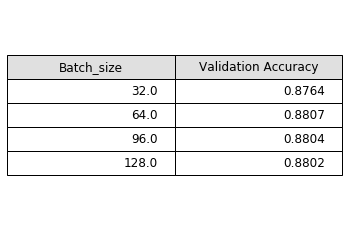

In [8]:
# fetch the data
(train_x, train_y), (test_x, test_y) = load_data()

# cross validation to choose batch_size
batch_sizes=[32,64,96,128]
cross_validation(batch_sizes,train_x,train_y,5)

The followin table gives the result of average validation accuray for different batch sizes. We can find there are no much difference between the batch sizes. 128 has the best performance, however, combine with the running speed, 128 is faser than 64, so we choose 128 batch size here.

Epoch 1/10
60000/60000 [==============================] - 3s 55us/step - loss: 0.5029 - accuracy: 0.8187
Epoch 2/10
60000/60000 [==============================] - 3s 54us/step - loss: 0.3666 - accuracy: 0.8654
Epoch 3/10
60000/60000 [==============================] - 3s 54us/step - loss: 0.3302 - accuracy: 0.8778
Epoch 4/10
60000/60000 [==============================] - 3s 54us/step - loss: 0.3077 - accuracy: 0.8852
Epoch 5/10
60000/60000 [==============================] - 3s 54us/step - loss: 0.2914 - accuracy: 0.8910
Epoch 6/10
60000/60000 [==============================] - 3s 54us/step - loss: 0.2768 - accuracy: 0.8967
Epoch 7/10
60000/60000 [==============================] - 3s 54us/step - loss: 0.2676 - accuracy: 0.8983
Epoch 8/10
60000/60000 [==============================] - 3s 54us/step - loss: 0.2561 - accuracy: 0.9032
Epoch 9/10
60000/60000 [==============================] - 3s 54us/step - loss: 0.2455 - accuracy: 0.9061
Epoch 10/10
60000/60000 [==============================

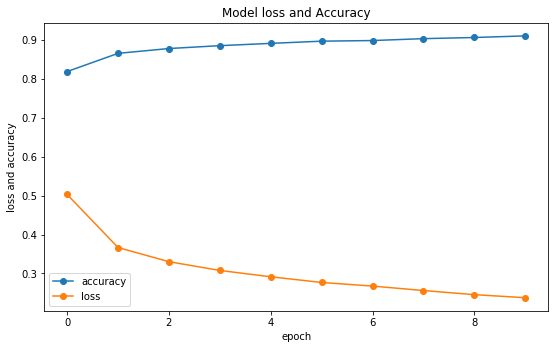

In [13]:
# get and train the model
model=get_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_x, train_y, batch_size=128, epochs=10)

# plot fit result
fig=plt.figure(figsize=(7,4))
ax=fig.add_axes([0,0,1,1])
ax.plot(history.history['accuracy'],'-o')
ax.plot(history.history['loss'],'-o')
plt.title('Model loss and Accuracy')
ax.set_ylabel('loss and accuracy')
ax.set_xlabel('epoch')
ax.legend(['accuracy', 'loss'])
plt.show()

This figure visualizes the fitting result of loss and accuracy. X-axis is the epoch times, y-axis is the loss and accuracy. From this figure, we can find the fitting result is not bad. Accuracy is growing from 0.82 to the end of 0.91, loss is desceding from a high value of 0.5 to very low at the end of 0.24.  

<b>Model tuning</b> We can also create a model and complie the model with optimizer of SDG, to see why we choose Adam in the model compile. 

Epoch 1/10
60000/60000 [==============================] - 2s 42us/step - loss: 1.0748 - accuracy: 0.6655
Epoch 2/10
60000/60000 [==============================] - 3s 42us/step - loss: 0.6647 - accuracy: 0.7753
Epoch 3/10
60000/60000 [==============================] - 3s 42us/step - loss: 0.5829 - accuracy: 0.8038
Epoch 4/10
60000/60000 [==============================] - 3s 42us/step - loss: 0.5405 - accuracy: 0.8158
Epoch 5/10
60000/60000 [==============================] - 3s 42us/step - loss: 0.5097 - accuracy: 0.8258
Epoch 6/10
60000/60000 [==============================] - 3s 42us/step - loss: 0.4894 - accuracy: 0.8314
Epoch 7/10
60000/60000 [==============================] - 3s 42us/step - loss: 0.4735 - accuracy: 0.8359
Epoch 8/10
60000/60000 [==============================] - 3s 42us/step - loss: 0.4596 - accuracy: 0.8404
Epoch 9/10
60000/60000 [==============================] - 3s 42us/step - loss: 0.4471 - accuracy: 0.8453
Epoch 10/10
60000/60000 [==============================

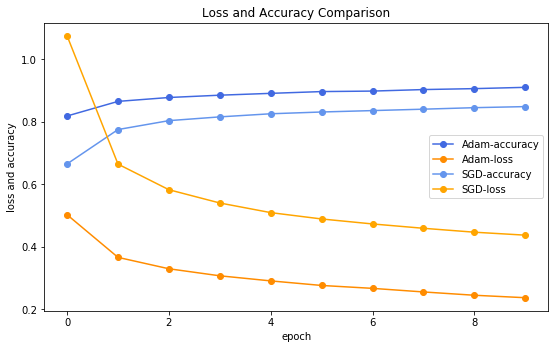

In [14]:
# get the samle model but sdg optimizer
model_sgd=get_model()
model_sgd.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
# train the model with same data, same batch_size, and same epochs
history_sgd=model_sgd.fit(train_x, train_y, batch_size=128, epochs=10)

# plot comparsion
fig=plt.figure(figsize=(7,4))
bx=fig.add_axes([0,0,1,1])
bx.plot(history.history['accuracy'],'-o',color="royalblue")
bx.plot(history.history['loss'],'-o',color="darkorange")
bx.plot(history_sgd.history['accuracy'],'-o',color="cornflowerblue")
bx.plot(history_sgd.history['loss'],'-o',color="orange")
plt.title('Loss and Accuracy Comparison')
bx.set_ylabel('loss and accuracy')
bx.set_xlabel('epoch')
bx.legend(['Adam-accuracy', 'Adam-loss','SGD-accuracy','SGD-loss'])
plt.show()

Compare the SDG optimizer with Adam optimizer, we can find that in every epoch, Adam has a higher accuracy and lower loss than SDG. At the final epoch, Adam has 7 more precent of accuracy than SDG. We then conclude that Adam has a better performance than SDG so that we choose Adam optimizer in this model.

###  Evaluating the model on some test data

After we fit the training data to the model, we can finally evaulate the test data. We input the test set and real set to the model evaluate funciton, use default batch size of 128. The return result saves the loss value in frist place and accuracy value in second place.

We can also evaulate the model by f1 scores. F1 score is a measure of a test’s accuracy, too. It is calculated with the precision and recall of a test. We use sklearn metrix function to calculate the f1 score here.

In [19]:
loss_and_metrics = model.evaluate(test_x, test_y, batch_size=128) # evaulate function
print("Test loss: %.4f \nTest Accuracy: %.4f" %(loss_and_metrics[0],loss_and_metrics[1]))

10000/10000 [==============================] - 0s 12us/step
Test loss: 0.3362 
Test Accuracy: 0.8834


We can see the overall loss for 10,000 test data is 0.34 and the overall accuracy is 0.88. The loss is a not very high and the accuracy is not very bad. Thus, after 10 times iterating the tarining data, we can still get almost 90% accuracy of the test data.

In [18]:
y_pred = model.predict(test_x, batch_size=128) # predict the result of each class
y_pred_bool = np.argmax(y_pred, axis=1) # get the predict class with max value
print(classification_report(test_label, y_pred_bool))

              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84      1000
         1.0       0.99      0.97      0.98      1000
         2.0       0.79      0.82      0.80      1000
         3.0       0.86      0.93      0.89      1000
         4.0       0.88      0.64      0.74      1000
         5.0       0.98      0.97      0.97      1000
         6.0       0.67      0.73      0.70      1000
         7.0       0.96      0.94      0.95      1000
         8.0       0.98      0.97      0.98      1000
         9.0       0.95      0.97      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



F1 score is a measure to use if we can seek a balance between precision and recall. From the f1 score above, we can see that except class 6, the others all preforme very good. 